In [ ]:
import logging
import qcodes as qc

# Matplot plots
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

from qcodes.utils.dataset.doNd import plot as doNd_plot
from qcodes.logger import start_all_logging
from qcodes.parameters import Parameter
import numpy as np
from time import sleep

# qcodes imports 
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
    plot_by_id, 
    do1d
)

from cappy.balancer import Balancer
from cappy.config import TEST_STATION_CONFIG, qc_dbpath

# Live plotting with Plottr
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr

In [ ]:
## Qcodes logger
# log = logging.getLogger("balance_logger")
# from qcodes.logger import start_all_logging
# start_all_logging()

In [ ]:
# Global Constants
LIVE_PLOT = True
SAVE_DATA = True
EXP_NAME = "trans_conductance"
SAMPLE_NAME = "run_2"
INT_TIME = 2    # lockin integration time

## Balancing arguements
FREQ = 50000
DELTA = (150, 150)
INITIAL = (10, 10)
Cstand = 10  # nF
DRIVE = 300

In [ ]:
station = qc.Station(config_file=str(TEST_STATION_CONFIG))

dac = station.load_instrument("acdac")
li = station.load_instrument("lockin")
yoko = station.load_instrument("yoko")
keithley = station.load_instrument("keithley")

# dac.display_mode('REMOTE')

Traceback (most recent call last):
  File "c:\Users\barreralab\.vscode\extensions\ms-python.python-2024.20.0-win32-x64\python_files\python_server.py", line 130, in exec_user_input
    retval = callable_(user_input, user_globals)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 3, in <module>
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\station.py", line 603, in load_instrument
    instr = instr_class(name=name, **instr_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\instrument\instrument_meta.py", line 36, in __call__
    new_inst = super().__call__(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\barreralab\OneDrive - University of Toronto\Documents\InstrumentDrivers\src\barreralabdrivers\drivers\ACDAC_9106.py", line 85, in __init__
    super().__init__(name, address, terminator

In [ ]:
dac.ch4.voltage(400)
dac.frequency(10000)
dac.display_mode("NORMAL")

vdd = yoko.channel1.voltage
vg = yoko.channel2.voltage

idd = yoko.channel1.current
ig = yoko.channel2.current
vds = keithley.amplitude

In [ ]:
vdd(0.1)
dac.ch2.voltage(100)

In [ ]:
# Setup qcodes database
initialise_or_create_database_at(qc_dbpath)

# Initialize Experiment
balance_exp = load_or_create_experiment(
    experiment_name=EXP_NAME,
    sample_name=SAMPLE_NAME
)

In [6]:
# equipment setup 

# ch3 = control, ch1 = reference, ch2 = drive
balancer = Balancer(dac.ch3, dac.ch1, dac.ch2, li, dac.frequency, INT_TIME)

def setup():
    pass
def teardown():
    pass

In [8]:
# Initial balance
def balance_initial():
    balancer.excite(DRIVE, DRIVE, FREQ)
    null_voltages = balancer.balance(INITIAL, DELTA, null=True)
    c_meas = balancer.calculate_capacitance(Cstand)
    print(f"null voltages = {null_voltages}")
    print(f"Balance Point Capacitance: {c_meas} nF")

balance_initial()

Kr1, Kr2 = (0.014805396399999988, 0.8208165628199999)
Kc1, Kc2 = (-0.8208027482, 0.01437994962)
P = 0.0003159041083655359
null voltages = (60.98958988097745, -7.431810478427984)
Balance Point Capacitance: 2.032986329365915 nF


# Run Experiment

In [ ]:
START = 0 
STOP = -0.7
SAMPLES = 300
INT_TIME = 0.3

dac.display_mode("REMOTE")
# axes = do1d(
#     v.voltage,
#     START,
#     STOP,
#     SAMPLES,
#     INT_TIME,
#     li.R,
#     do_plot=True,
#     show_progress=True,
#     exp=test_sweep,
# )

In [ ]:
# Initialize measurement object
meas = Measurement(exp=balance_exp, station=station, name='balance_meas')

#TODO Register your parameters here
meas.register_parameter(vg)
meas.register_parameter(vds, setpoints=(vg, ))
# meas.register_parameter(idd, setpoints=(vg, ))
# meas.register_parameter(ig, setpoints=(vg, ))
meas.register_parameter(li.R, setpoints=(vg, ))
meas.register_parameter(li.P, setpoints=(vg, ))
meas.add_before_run(setup, args=())
meas.add_after_run(teardown, args=())
meas.write_period = 1

In [ ]:
# run measurement
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # Default fallback font in Matplotlib

if LIVE_PLOT:
    jobs = bg.BackgroundJobManager()
    jobs.new(inspectr.main, qc_dbpath)

with meas.run() as datasaver:
    for set_v in np.linspace(START, STOP, SAMPLES):
        # set yoko channel 1 voltage
        vg(set_v)

        # get keithley voltage reading
        get_vds = vds()

        
        # get_idd = idd()
        # get_ig = ig()

        get_lR = li.R()
        get_lP = li.P()
        
        # wait time for keithley to stabilize TODO: investigate more sophisticated methods 
        sleep(INT_TIME)

        if SAVE_DATA:
            # save data to database
            datasaver.add_result((vg, set_v), (vds, get_vds))
            # datasaver.add_result((vg, set_v), (idd, get_idd))
            # datasaver.add_result((vg, set_v), (ig, get_ig))

            datasaver.add_result((vg, set_v), (li.R, get_lR))
            datasaver.add_result((vg, set_v), (li.P, get_lP))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset
    run_id = datasaver.run_id

    # if SAVE_DATA:
    #     dataset.export("csv", path='.')

dataset_1d = load_by_run_spec(experiment_name=EXP_NAME, captured_run_id=run_id)

Starting experimental run with id: 10. 


([<Axes: title={'center': 'Run #10, Experiment test_balance (dry)'}, xlabel='Voltage (mV)', ylabel='Magnitude (μV)'>],
 [None])

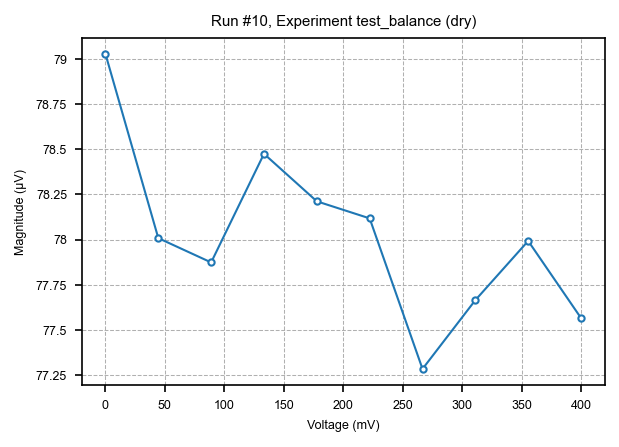

In [13]:
plot_dataset(dataset)

In [ ]:
def ramp_down(param):
    curr = param()
    points = np.linspace(curr, 0, 50)
    for p in points:
        param(p)
        sleep(0.01)

In [ ]:
ramp_down(vg)
ramp_down(vdd)
ramp_down(dac.ch2.voltage)

dac.display_mode("NORMAL")

## TODO

- [ ] Quantum Designs Cryostatat 6000, Magnetic Field and Temperature params
- [ ] Matplotlib font warnings: clear cache using `rm ~/.cache/matplotlib -rf `
- [ ] Yokogs20 driver: functionality to read current while in voltage source mode and vv 
- [ ] Use dond or measureme instead of annoying measurement object setup  